# Background

The data was obtained from Kaggle (https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis) with a CC0: Public Domain license. The data was inspected, features were created/modified and outliers removed. The created features/modified were:

Created:
- Customer Age
- Total Expenses
- Seniority
- Child Count (Number of Children)
- Has Child (Boolean for children)

Modified:
- Marital Status
- Education

Outliers were removed using scatterplots and boxplots with visual inspection. The prepared data was pickled along with the features to be used for clustering in a list. Pearson correlations were also calculated and the following was determined:

- Income vs Expenses are correlated positively (+0.83)
- Children vs Income (-0.35) and Children vs Expenses (-0.5) are negativly correlated

The rest show little to no correlation and should be easy to segment individually. PCA might be useful to help reduce dimensions with the non-correlated sets.

# Goal

Apply K-means and PCA to segment the data based on the features to use.

# Imports

In [8]:
# data tools
import numpy as np
import pandas as pd
import pickle as pkl


# inspection tools
# from IPython.core.display import HTML
# from dataprep.eda import plot, plot_correlation, create_report, plot_missing

# date handling
# import datetime
# from datetime import date

# graphing
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
sns.set()

# machine learning
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# import warnings
# warnings.filterwarnings('ignore')

# Functions



In [23]:
# Function to display informative elbow method for clusters

def test_clusters(X, random_state, max_clusters, metric='distortion'):
    model = KMeans(random_state=random_state, n_init=10, max_iter=300, tol=1e-04, init='k-means++')
    if metric == 'distortion':
        elb_visualiser = KElbowVisualizer(model, k=(1,max_clusters), metric=metric)
    else:
        elb_visualiser = KElbowVisualizer(model, k=(2,max_clusters), metric=metric)
    elb_visualiser.fit(X)
    return elb_visualiser.show()

# Function to display informative silhouette method for clusters

def silhouette_clusters(X, random_state, number_of_clusters):
    model = KMeans(n_clusters=number_of_clusters, random_state=random_state, n_init=10, max_iter=300, tol=1e-04, init='k-means++')
    
    sil_visualiser = SilhouetteVisualizer(model)
    sil_visualiser.fit(X)
    return sil_visualiser.show()

# Function to perform PCA analysis
def pca_analysis(X, num_components):
    if num_components == 'find':
        pca = PCA()
        pca.fit(X)
    else:
        pca = PCA(n_components=num_components)
        pca.fit(X)
    return pca

# function to get component loadings from PCA
def get_comp_loadings(pca_components, cols, index):
    df_pca_comp = pd.DataFrame(data = pca_components, columns=cols, index = index)
    return df_pca_comp


# Load Data

In [24]:
with open('customer_data_without_outliers.pickle', 'rb') as handle:
    dict = pkl.load(handle)

In [25]:
# Unpack the data
data = dict['data']
features = dict['cluster_features']

#  Select clustering features
segm_data = data[features].copy()
segm_data

Income  Recency  Customer Age  Total Expenses  Seniority  Children
ID                                                                        
5524   58138.0       58            57            1617  25.333333         0
2174   46344.0       38            60              27   7.000000         2
4141   71613.0       26            49             776  13.633333         0
6182   26646.0       26            30              53   7.866667         1
5324   58293.0       94            33             422   8.600000         1
...        ...      ...           ...             ...        ...       ...
10870  61223.0       46            47            1341  15.933333         1
4001   64014.0       56            68             444   3.866667         3
7270   56981.0       91            33            1241   8.400000         0
8235   69245.0        8            58             843   8.433333         1
9405   52869.0       40            60             172  23.966667         2

[2203 rows x 6 columns]

# Scale the data

In [26]:
# Use standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(segm_data)

# Normalisation
# X_norm = normalize(X_std,norm='l2')

X = X_scaled.copy()

# PCA

In [27]:
# get the components
pca = pca_analysis(X, 'find')

#show the number of components
pca.components_.shape

(6, 6)

In [28]:
number_of_components = pca.components_.shape[0]

Text(0, 0.5, 'Cumulative Explained Varience')

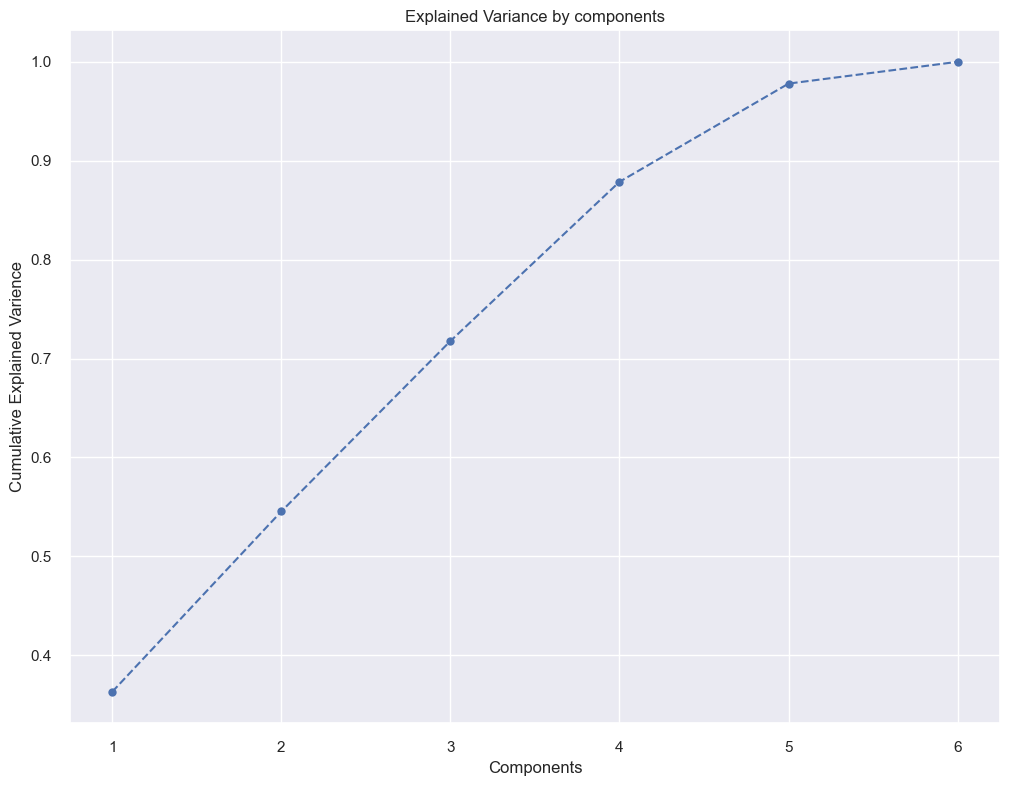

In [29]:
# Plot cumulative variance vs components

plt.figure(figsize=(12,9))
plt.plot(range(1, number_of_components+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title("Explained Variance by components")
plt.xlabel("Components")
plt.ylabel("Cumulative Explained Varience")

70% Explained varience is a good benchmark, we can reduce the dimensionality to 3 components

In [30]:
Number_of_components_to_use = 3
pca = pca_analysis(X, Number_of_components_to_use)

## PCA Results

In [31]:
pca_comp = get_comp_loadings(pca.components_, features, ['Component 1', 'Component 2', 'Component 3'])
pca_comp

Income   Recency  Customer Age  Total Expenses  Seniority  \
Component 1  0.605806  0.013145      0.136901        0.640739   0.083189   
Component 2  0.174998  0.151226      0.838228       -0.023711  -0.259683   
Component 3  0.083978 -0.681993     -0.054744       -0.046639  -0.712340   

             Children  
Component 1 -0.443416  
Component 2  0.419384  
Component 3 -0.123422

### PCA pearson correlations to features

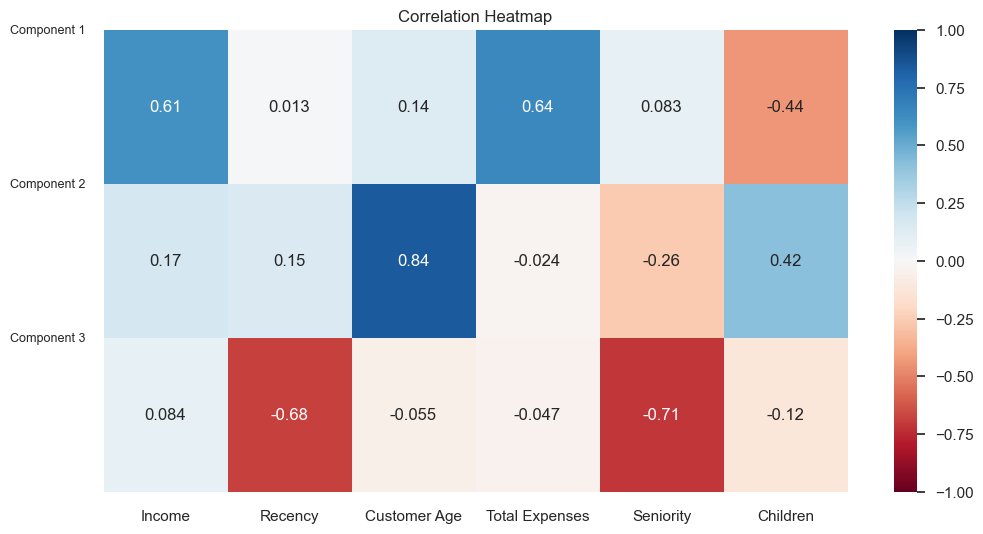

In [32]:
plt.figure(figsize=(12,6))
s = sns.heatmap(pca_comp,
               annot=True,
               cmap='RdBu',
               vmin=-1,
               vmax=1)
plt.yticks([0,1,2], ['Component 1', 'Component 2', 'Component 3'], rotation = 0, fontsize = 9)
plt.title("Correlation Heatmap")
plt.show()

It seems that Component 1 is positively correlated to Income (0.61) and Total Expenses (0.64) whilst negatively correlated with the number of children (-0.44). Component 2 seems positivly correlated with Age (0.84) and the number of children (0.42), whilst being negativly correlated with Seniority (-0.26). Component 3 is negativly correlated with Recency (-0.68) and Seniority (-0.71)

The rest are loosely correlated.

In [71]:
# get the PCA scores
scores_pca = pca.transform(X)
scores_pca

array([[ 2.10053826, -0.01202792, -1.25070243],
       [-1.32356812,  1.88629825,  0.88783529],
       [ 1.34729237, -0.15511948,  0.89624985],
       ...,
       [ 1.19125652, -0.90300296, -0.10455528],
       [ 0.79037361,  1.13303488,  1.64782153],
       [-0.76756638,  1.29345756, -0.93495013]])

# Hierarchical Clustering


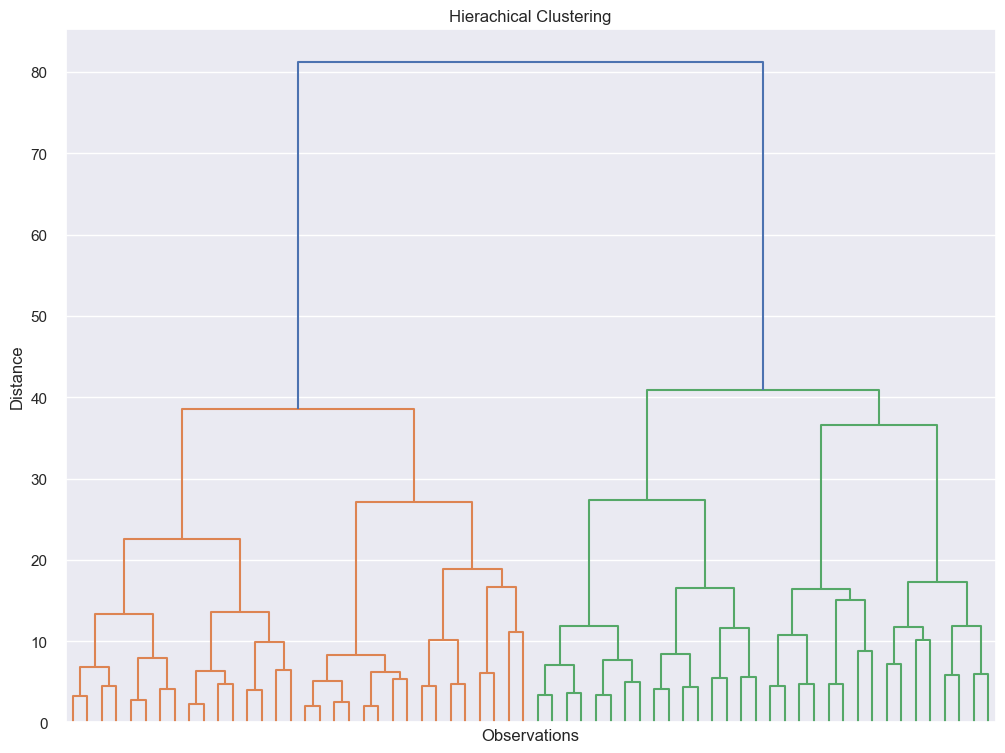

In [72]:
hier_clus = linkage(scores_pca, method='ward')

plt.figure(figsize=(12, 9))
plt.title("Hierachical Clustering")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hier_clus,
           truncate_mode='level',
           p=5,
           show_leaf_counts=False,
           no_labels=True,
           # color_threshold=0
           )
plt.show()

# K-means
## Choosing number of clusters

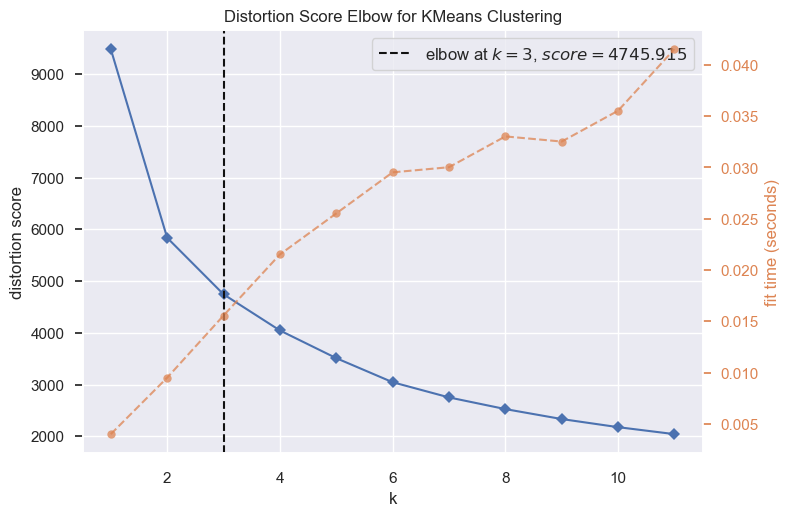

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [73]:
test_clusters(X=scores_pca, random_state=1, max_clusters=12, metric='distortion')

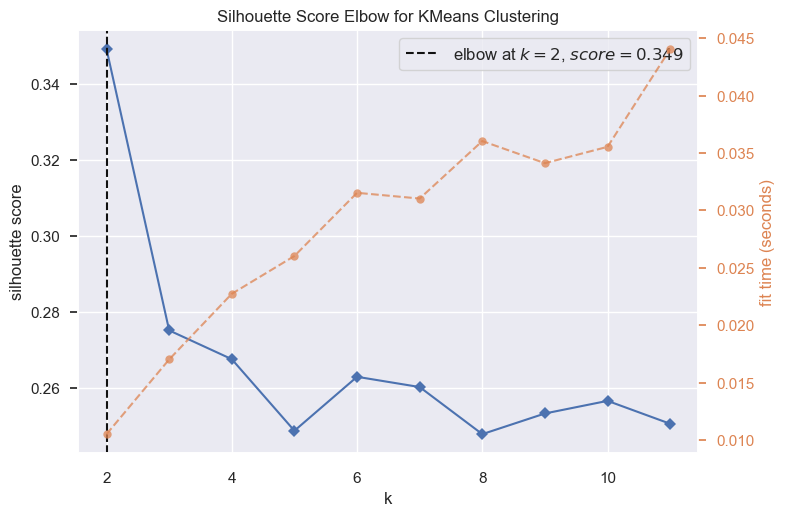

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [74]:
test_clusters(X=scores_pca, random_state=1, max_clusters=12, metric='silhouette')

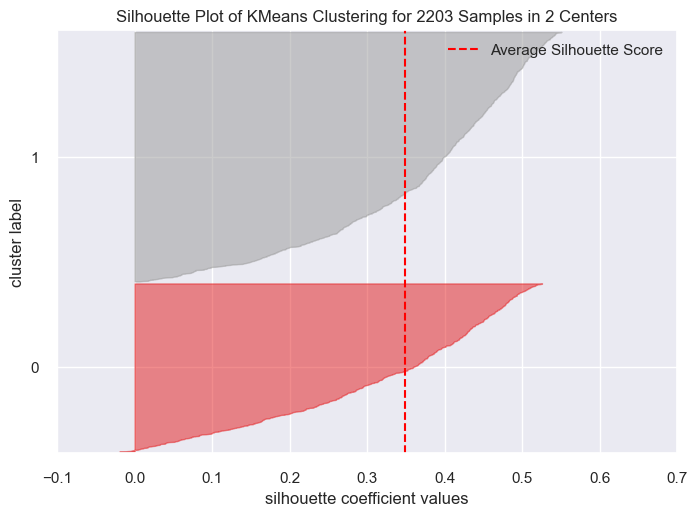

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2203 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [75]:
silhouette_clusters(X=scores_pca, random_state=1, number_of_clusters=2)

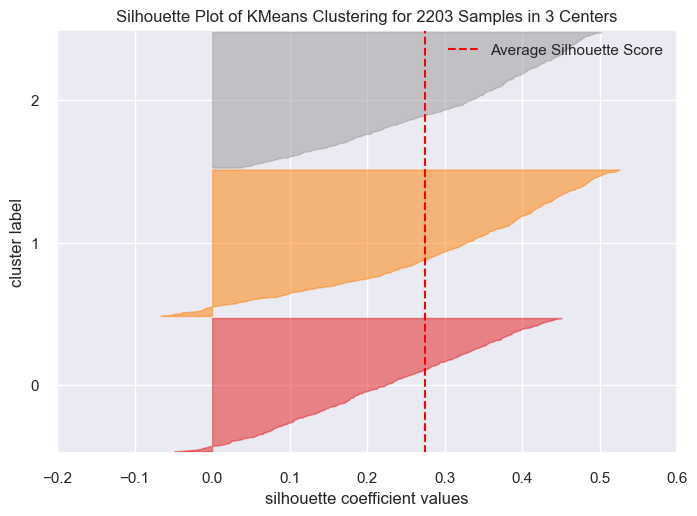

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2203 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [76]:
silhouette_clusters(X=scores_pca, random_state=1, number_of_clusters=3)

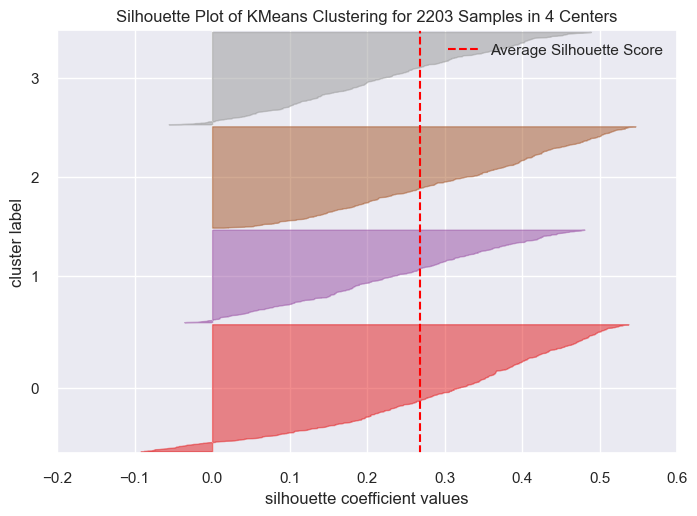

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2203 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [77]:
silhouette_clusters(X=scores_pca, random_state=1, number_of_clusters=4)

## Cluster selection

The number of clusters to select seem to point to choosing 2 clusters. This is based on the Silhoette score as well as the Dendrogram. We could choose 3 based on the elbow method, however often a simpler model is best. We will compare them side by side


In [78]:
# choose two clusters and fit
kmeans_2_clus = KMeans(n_clusters=2, init='k-means++', random_state=1)
kmeans_2_clus.fit(scores_pca)

KMeans(n_clusters=2, random_state=1)

In [79]:
# choose three clusters and fit
kmeans_3_clus = KMeans(n_clusters=3, init='k-means++', random_state=1)
kmeans_3_clus.fit(scores_pca)


KMeans(n_clusters=3, random_state=1)

In [80]:
# choose two clusters and fit
kmeans_4_clus = KMeans(n_clusters=4, init='k-means++', random_state=1)
kmeans_4_clus.fit(scores_pca)

KMeans(n_clusters=4, random_state=1)

## Results PCA K-means

In [81]:
# Copying unscaled data and merging with PCA components for 2, 3 and 4 clusters
segm_pca_kmeans_2_clus = pd.concat([segm_data[features].reset_index(drop=False),
                                    pd.DataFrame(scores_pca)], axis=1)
segm_pca_kmeans_2_clus.columns.values[-3:] = ['Component 1',
                                              'Component 2',
                                              'Component 3']
segm_pca_kmeans_3_clus = segm_pca_kmeans_2_clus.copy()
segm_pca_kmeans_4_clus = segm_pca_kmeans_2_clus.copy()

# copy the labels from the models
segm_pca_kmeans_2_clus['Segment K-means PCA'] = kmeans_2_clus.labels_
segm_pca_kmeans_3_clus['Segment K-means PCA'] = kmeans_3_clus.labels_
segm_pca_kmeans_4_clus['Segment K-means PCA'] = kmeans_4_clus.labels_

# Calculate the means per cluster
segm_pca_kmeans_2_clus_means = segm_pca_kmeans_2_clus.groupby(
    ['Segment K-means PCA']).mean().reset_index(drop=False)
segm_pca_kmeans_3_clus_means = segm_pca_kmeans_3_clus.groupby(
    ['Segment K-means PCA']).mean().reset_index(drop=False)
segm_pca_kmeans_4_clus_means = segm_pca_kmeans_4_clus.groupby(
    ['Segment K-means PCA']).mean().reset_index(drop=False)

# Calculate the number of observations
segm_pca_kmeans_2_clus_means['N Obs'] = segm_pca_kmeans_2_clus[[
    'Segment K-means PCA', 'Customer Age']].groupby(['Segment K-means PCA']).count()
segm_pca_kmeans_3_clus_means['N Obs'] = segm_pca_kmeans_3_clus[[
    'Segment K-means PCA', 'Customer Age']].groupby(['Segment K-means PCA']).count()
segm_pca_kmeans_4_clus_means['N Obs'] = segm_pca_kmeans_4_clus[[
    'Segment K-means PCA', 'Customer Age']].groupby(['Segment K-means PCA']).count()

# Calculate the percentage of observations
segm_pca_kmeans_2_clus_means['Percent Obs'] = (
    (segm_pca_kmeans_2_clus_means['N Obs']/segm_pca_kmeans_2_clus_means['N Obs'].sum())*100).round(2)
segm_pca_kmeans_3_clus_means['Percent Obs'] = (
    (segm_pca_kmeans_3_clus_means['N Obs']/segm_pca_kmeans_3_clus_means['N Obs'].sum())*100).round(2)
segm_pca_kmeans_4_clus_means['Percent Obs'] = (
    (segm_pca_kmeans_4_clus_means['N Obs']/segm_pca_kmeans_4_clus_means['N Obs'].sum())*100).round(2)

In [82]:
segm_pca_kmeans_2_clus_means.drop("ID", axis = 1)

Segment K-means PCA        Income    Recency  Customer Age  Total Expenses  \
0                    0  71448.630214  49.854566     47.653890     1228.509583   
1                    1  38248.938450  48.474924     43.360942      187.193769   

   Seniority  Children  Component 1  Component 2  Component 3  N Obs  \
0  15.803758  0.472379     1.566897     0.034813    -0.002570    887   
1  14.501798  1.270517    -1.056108    -0.023464     0.001732   1316   

   Percent Obs  
0        40.26  
1        59.74

In [83]:
segm_pca_kmeans_3_clus_means.drop("ID", axis = 1)

Segment K-means PCA        Income    Recency  Customer Age  Total Expenses  \
0                    0  47192.137006  54.336158     52.817797      301.810734   
1                    1  72958.493557  48.784794     46.416237     1299.487113   
2                    2  32938.406120  44.070932     36.047288      158.485396   

   Seniority  Children  Component 1  Component 2  Component 3  N Obs  \
0  13.473917  1.538136    -0.729308     0.945614    -0.088838    708   
1  15.905498  0.394330     1.719306    -0.097096     0.031201    776   
2  15.605146  0.968011    -1.137456    -0.826353     0.053805    719   

   Percent Obs  
0        32.14  
1        35.22  
2        32.64

In [84]:
segm_pca_kmeans_4_clus_means.drop("ID", axis = 1)

Segment K-means PCA        Income    Recency  Customer Age  Total Expenses  \
0                    0  74263.286136  48.330383     46.087021     1357.538348   
1                    1  46974.237323  30.805274     48.217039      273.259635   
2                    2  30903.387037  47.388889     34.577778      152.731481   
3                    3  47792.483740  70.058943     52.117886      403.317073   

   Seniority  Children  Component 1  Component 2  Component 3  N Obs  \
0  15.949951  0.308260     1.866880    -0.164194     0.053747    678   
1   9.106085  1.326572    -0.759289     0.541763     0.984726    493   
2  17.005247  0.905556    -1.164759    -1.020189    -0.162874    540   
3  17.512398  1.502033    -0.533426     0.803123    -0.882030    492   

   Percent Obs  
0        30.78  
1        22.38  
2        24.51  
3        22.33

It seems that choosing 2 clusters result in a 40/60 split in the data. However choosing 3 clusters results in a more homogeous split. Choosing 4 clusters is still relativly homogenous. In general we can find better sepration in Age and children with more clusters which also gives more divisions for Income and spending.

Assuming 2 clusters we observe the following on average:

- Cluster 0 = High income, High Expenses, zero to 1 child = Career focused, Well-off
- Cluster 1 = Low income, Low Expenses, 1 or more children = Family orientated

Assuming 3 clusters we observe the following on average:

- Cluster 0 = Med income, Elder, Med expenses, 1 or more children = Family oriented, conservative spender
- Cluster 1 = High income, Middle Aged, High Expenses, 0 to 1 Child = Career focused, Well off
- Cluster 2 = Low income, Younger, Low Expenses, 0 to 1 Child = Young professionals, savvy spender


Assuming 4 clusters we observe the following on average:

- Cluster 0 = High income, middle aged, High expenses, , 0-1 child = Career focused, well off
- Cluster 0 = Low-med income, middle-elder, low-med expenses, 2 or more children = Family oriented, conservative spender 
- Cluster 1 = Low income, younger, low expenses, 0-1 child = Young professionals, savvy spender 
- Cluster 2 = Med income, Elder, Med expenses, 0-1 child = Senior career focused, intermediate spenders


## Rename the segments

In [94]:
segm_kmeans_2_clust_means.rename({0: 'Career focused, Well-off',
                                 1: 'Family orientated'})



Segment K-means        Income    Recency  \
Career focused, Well-off                0  71579.564972  49.823729   
Family orientated                       1  38211.398331  48.497724   

                          Customer Age  Total Expenses  Seniority  Children  \
Career focused, Well-off     47.561582     1233.338983  15.801092  0.481356   
Family orientated            43.429439      185.531108  14.505564  1.263278   

                          N Obs  Percent Obs  
Career focused, Well-off    885        40.17  
Family orientated          1318        59.83

In [95]:
segm_kmeans_3_clust_means.rename({0: 'Young professionals, savvy spender',
                                 1: 'Career focused, Well off',
                                 2: 'Family oriented, conservative spender'})

Segment K-means        Income  \
Young professionals, savvy spender                   0  31664.703704   
Career focused, Well off                             1  72529.703474   
Family oriented, conservative spender                2  47515.071942   

                                         Recency  Customer Age  \
Young professionals, savvy spender     47.858974     36.920228   
Career focused, Well off               49.906948     46.736973   
Family oriented, conservative spender  49.197122     51.430216   

                                       Total Expenses  Seniority  Children  \
Young professionals, savvy spender         148.367521  15.409022  0.837607   
Career focused, Well off                  1282.442928  15.820761  0.415633   
Family oriented, conservative spender      285.225899  13.717458  1.680576   

                                       N Obs  Percent Obs  
Young professionals, savvy spender       702        31.87  
Career focused, Well off                 806        36.59  
Family oriented, conservative spender    695        31.55

In [96]:
segm_kmeans_4_clust_means.rename({0: 'Family oriented, conservative spender',
                                 1: 'Young professionals, savvy spender',
                                 2: 'Senior career focused, intermediate spenders',
                                 3: 'Career focused, well off'})

Segment K-means        Income  \
Family oriented, conservative spender                       0  43657.828054   
Young professionals, savvy spender                          1  32130.795022   
Senior career focused, intermediate spenders                2  58960.419593   
Career focused, well off                                    3  75550.945996   

                                                Recency  Customer Age  \
Family oriented, conservative spender         49.914027     48.628959   
Young professionals, savvy spender            49.581259     36.484627   
Senior career focused, intermediate spenders  41.985213     55.787431   
Career focused, well off                      54.700186     42.342644   

                                              Total Expenses  Seniority  \
Family oriented, conservative spender             208.085973  14.195852   
Young professionals, savvy spender                142.982430  14.975891   
Senior career focused, intermediate spenders      703.314233  14.399322   
Career focused, well off                         1426.277467  16.404407   

                                              Children  N Obs  Percent Obs  
Family oriented, conservative spender         2.110860    442        20.06  
Young professionals, savvy spender            0.847731    683        31.00  
Senior career focused, intermediate spenders  0.768946    541        24.56  
Career focused, well off                      0.303538    537        24.38

In [97]:
# Map the segments onto observations

In [98]:
segm_kmeans_2_clust['Labels'] = segm_kmeans_2_clust['Segment K-means'].map({0: 'Career focused, Well-off',
                                                                            1: 'Family orientated'})
segm_kmeans_3_clust['Labels'] = segm_kmeans_3_clust['Segment K-means'].map({0: 'Young professionals, savvy spender',
                                                                            1: 'Career focused, Well off',
                                                                            2: 'Family oriented, conservative spender'})
segm_kmeans_4_clust['Labels'] = segm_kmeans_4_clust['Segment K-means'].map({0: 'Family oriented, conservative spender',
                                                                            1: 'Young professionals, savvy spender',
                                                                            2: 'Senior career focused, intermediate spenders',
                                                                            3: 'Career focused, well off'})

# Plot the clusters

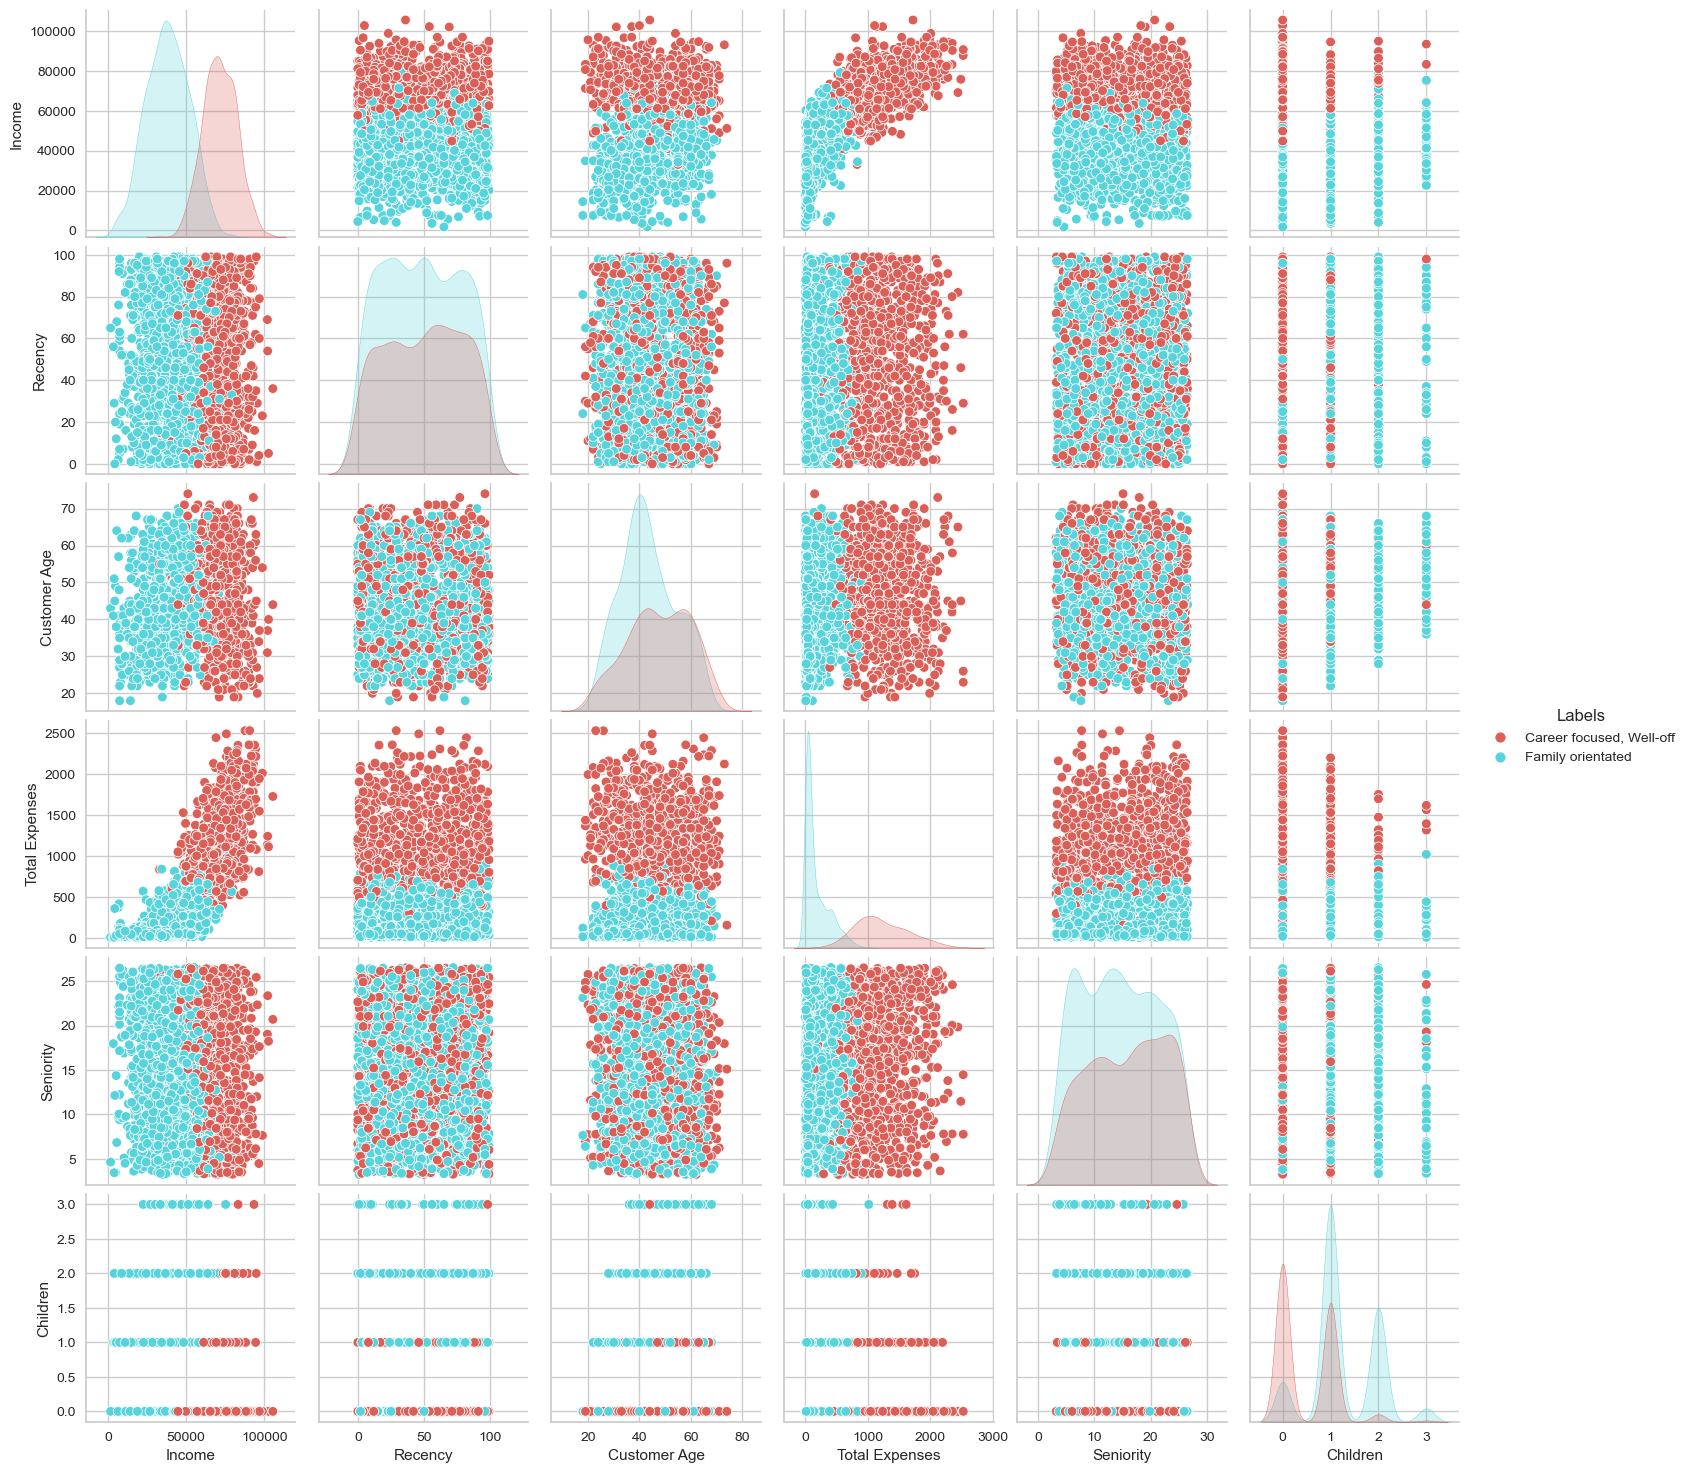

In [99]:
sns.pairplot(segm_kmeans_2_clust, vars=features, hue='Labels', palette=sns.color_palette('hls',2))

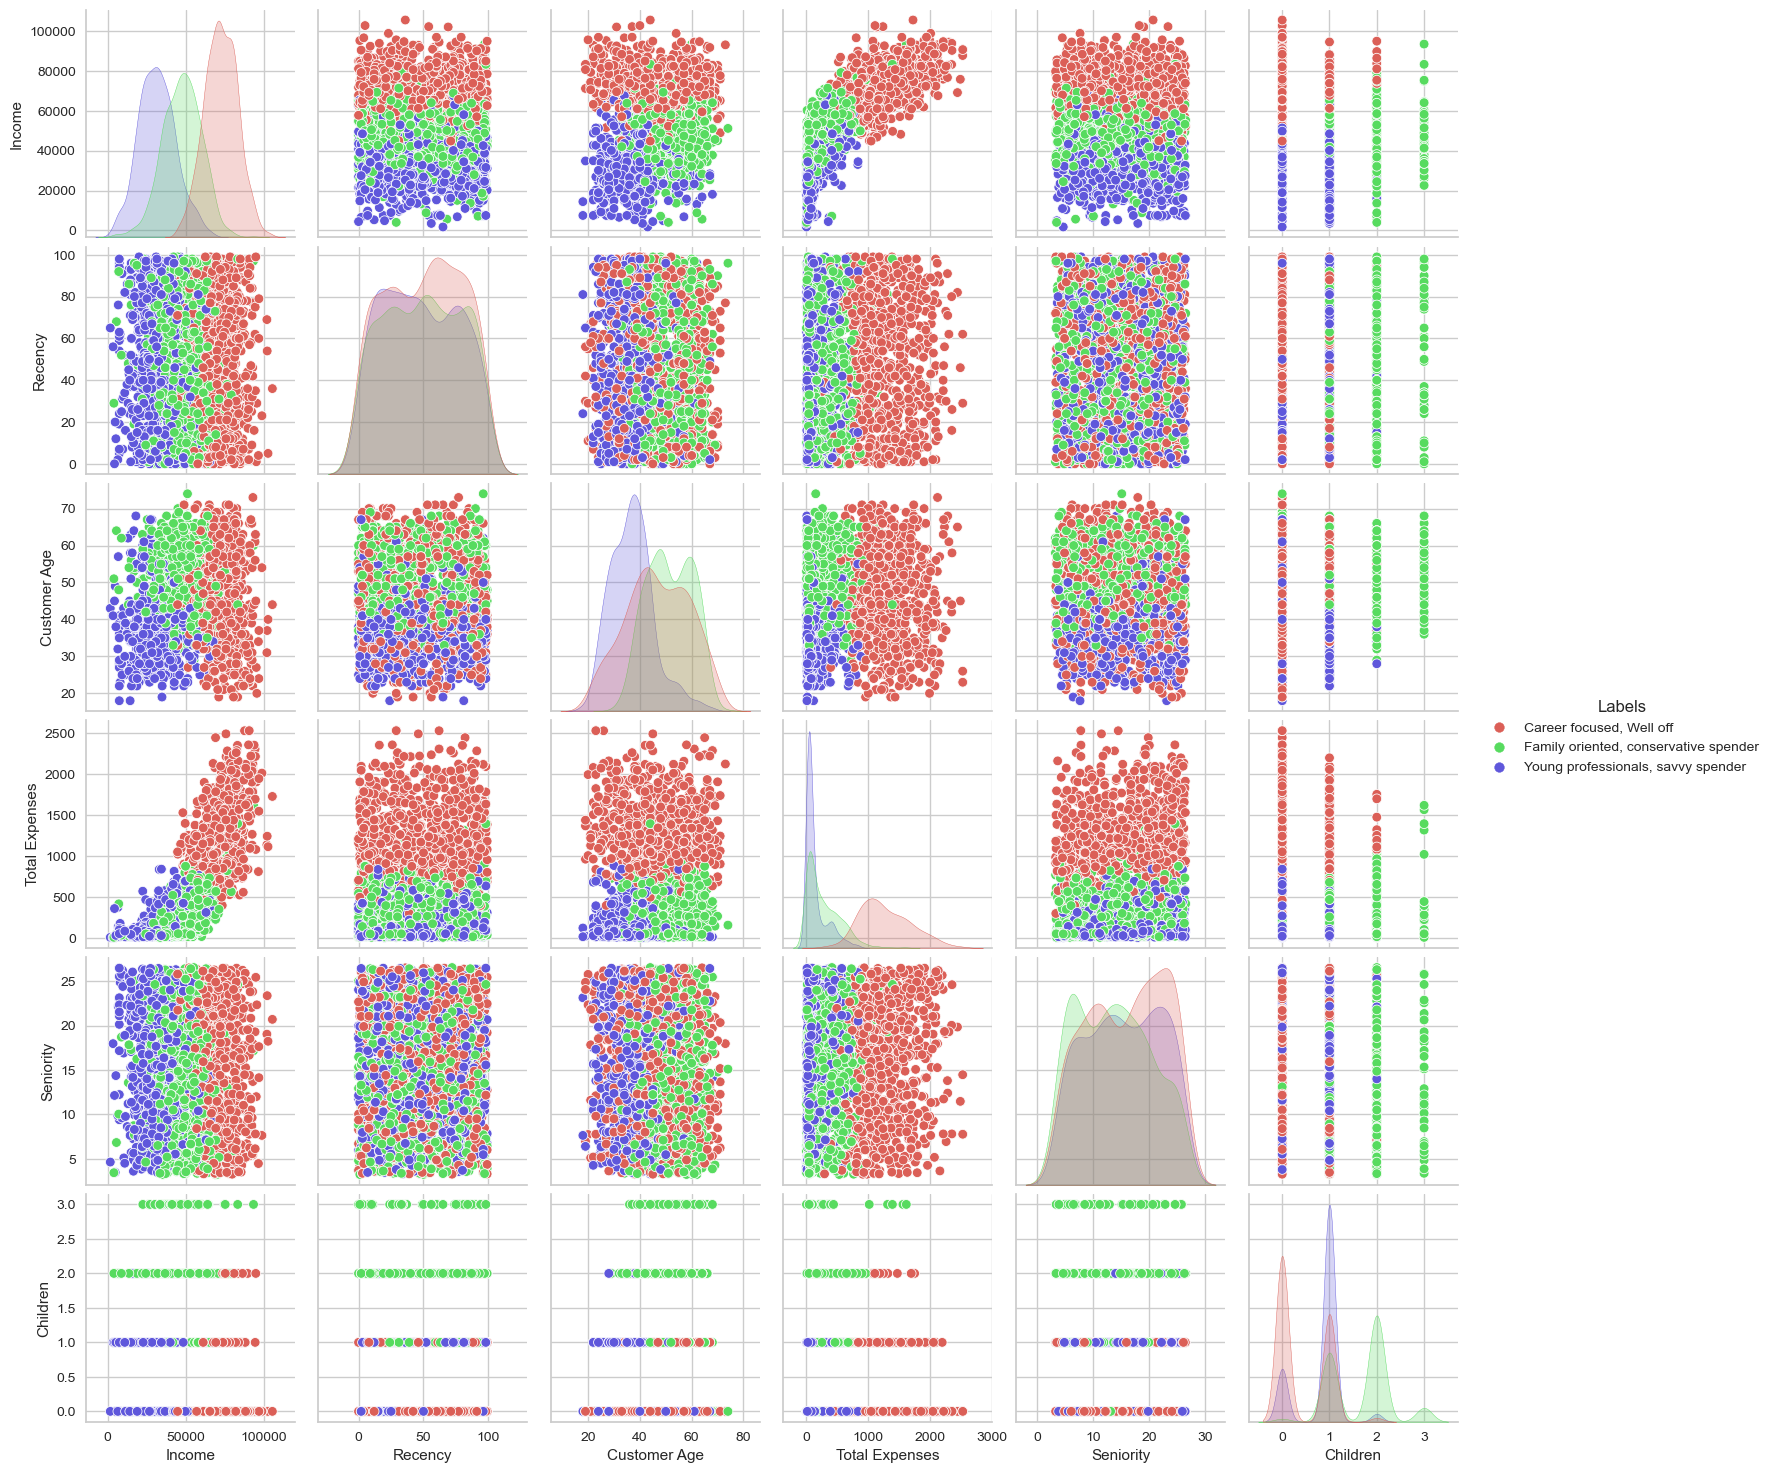

In [100]:
sns.pairplot(segm_kmeans_3_clust, vars=features, hue='Labels', palette=sns.color_palette('hls',3))

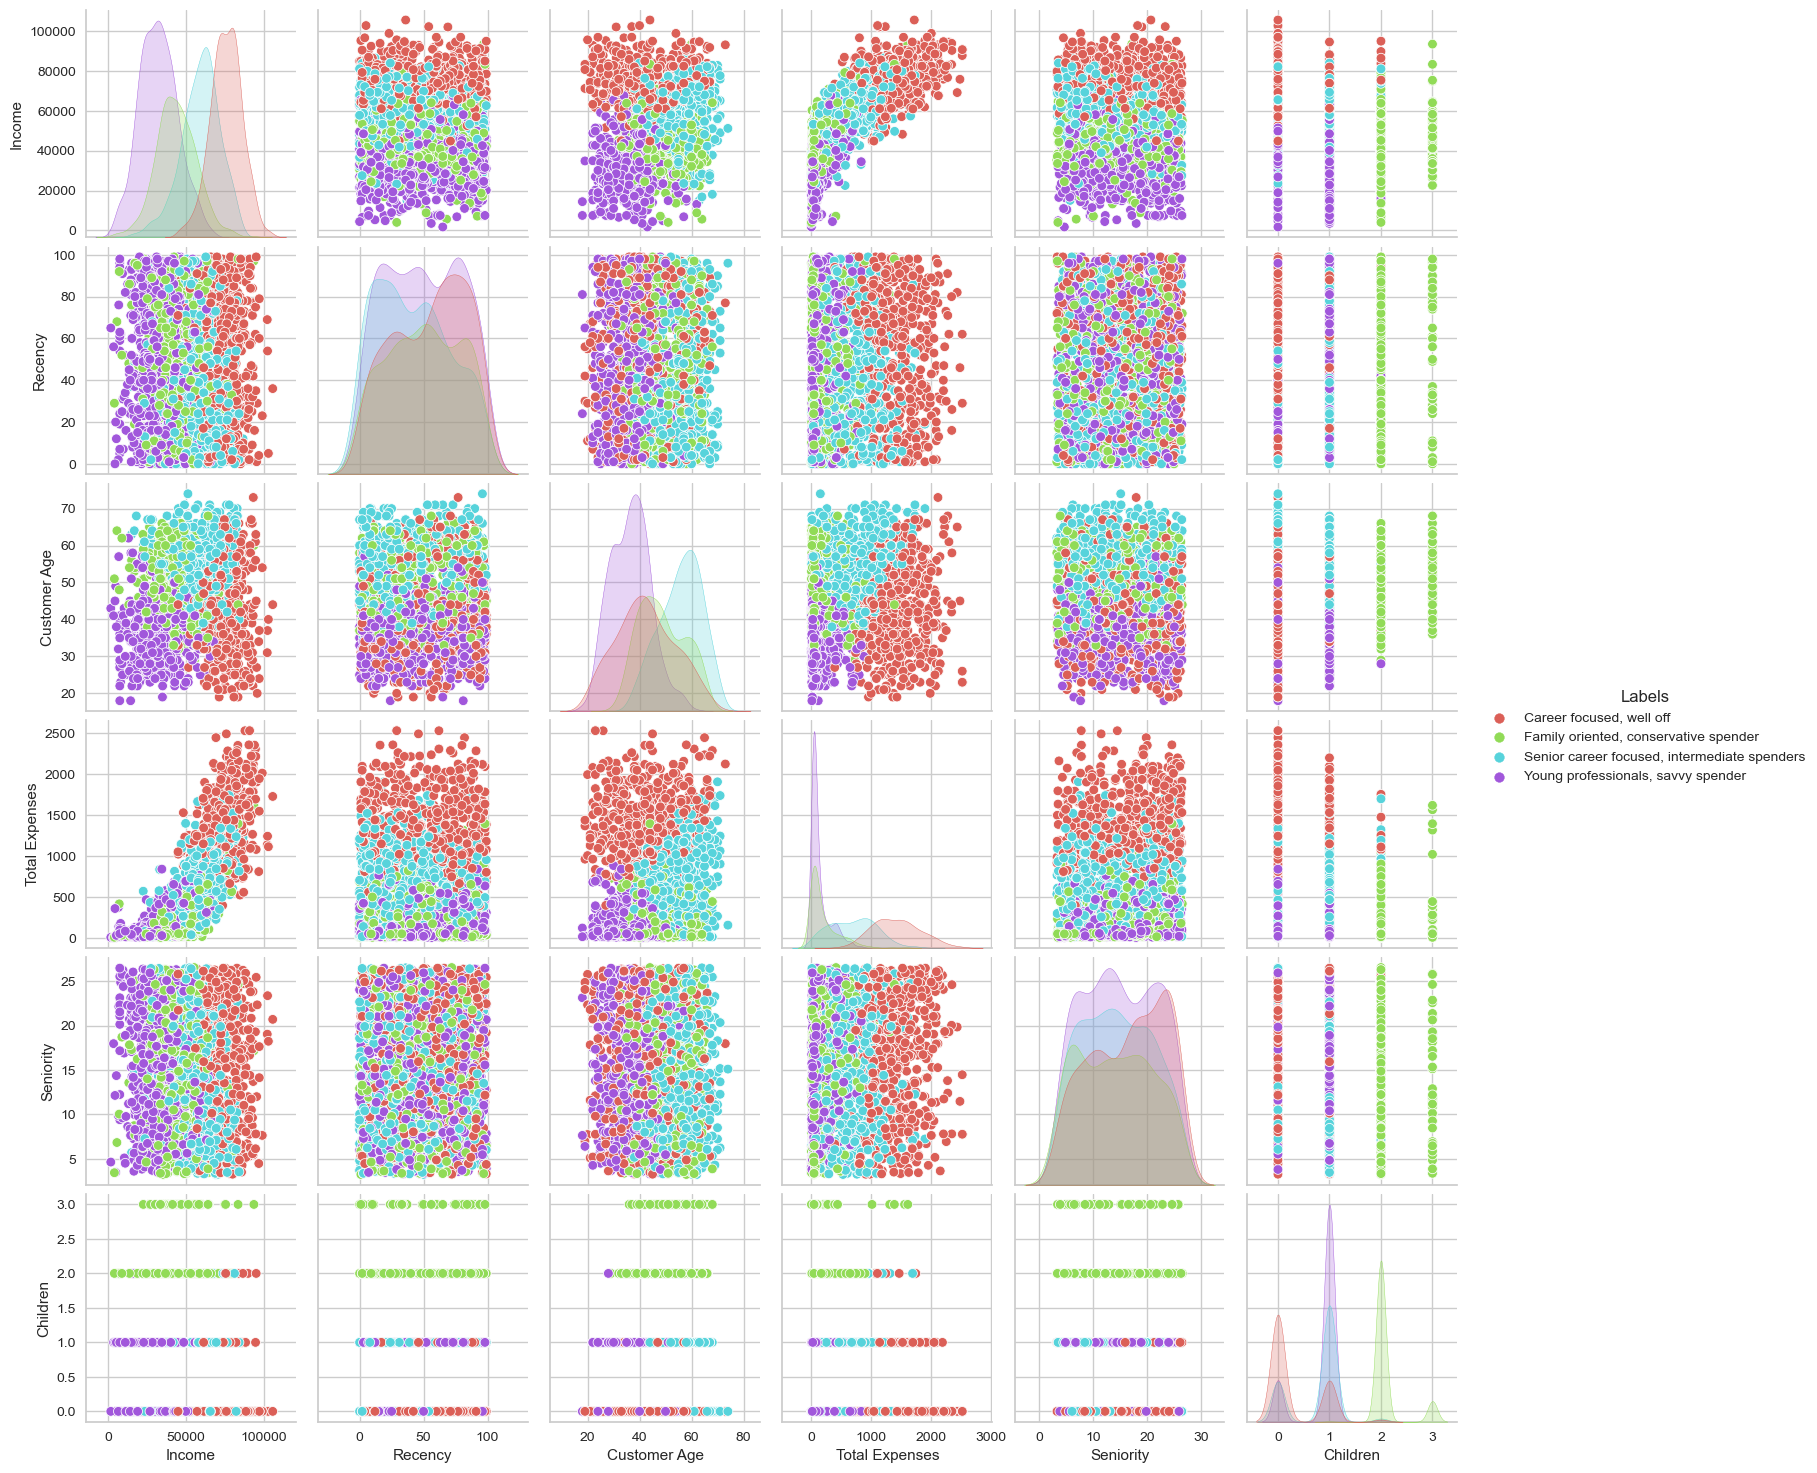

In [101]:
sns.pairplot(segm_kmeans_4_clust, vars=features, hue='Labels', palette=sns.color_palette('hls',4))